In [1]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 2.8MB/s 


In [126]:
# import libraries

import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

## Load the data

In [4]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [127]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [128]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [129]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,humidity_log_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,windSpeed_log_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,humidity_log_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,windSpeed_log_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,humidity_log_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,windSpeed_log_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,humidity_log_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,windSpeed_log_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,humidity_log_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,windSpeed_log_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,humidity_log_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,windSpeed_log_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_humidity_log_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_windSpeed_log_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_humidity_log_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_windSpeed_log_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_humidity_log_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_windSpeed_log_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_humidity_log_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_windSpeed_log_per_month,median_PM

In [130]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 212 columns):
 #   Column                                  Dtype         
---  ------                                  -----         
 0   datetime                                datetime64[ns]
 1   apparentTemperature                     float64       
 2   cloudCover                              float64       
 3   dewPoint                                float64       
 4   humidity                                float64       
 5   icon                                    object        
 6   precipIntensity                         float64       
 7   precipProbability                       float64       
 8   pressure                                float64       
 9   summary                                 object        
 10  temperature                             float64       
 11  uvIndex                                 float64       
 12  visibility                              float

#### Split the data for train and test

In [131]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [132]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [133]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

## Create functions for quick iterations and scoring

In [134]:
# function to run different models
def run_model(feats, model, cross_val):
    X = df_train[feats].values
    y = df_train['PM25_nie_log'].values
    
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [135]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(feats, model, cross_val, scoring, ax):

  X = df_train[feats].values
  y = df_train['PM25_nie_log'].values

  model_name = type(model).__name__

  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring=scoring,
                                       title=f'{model_name} Learning Curve', ax=ax);

##Define cross-validation and initiate simple models for benchmarking purpose

In [137]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
Dummy_model = DummyRegressor(strategy="mean")
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

# add all models to a list
models = [Dummy_model, DT_model, RF_model, XGB_model, LGBM_model]

###Run models on original darksky.net features

In [136]:
# select original features from darksky.net
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity',
              'precipProbability', 'pressure', 'temperature', 'uvIndex',
              'visibility', 'windBearing', 'windSpeed', 'icon_num']

In [138]:
# run models on time series split
for model in models:
    run_model(orig_feats, model, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4579, r2: 31.4%
LGBMRegressor RMSE: 0.4612, r2: 29.9%


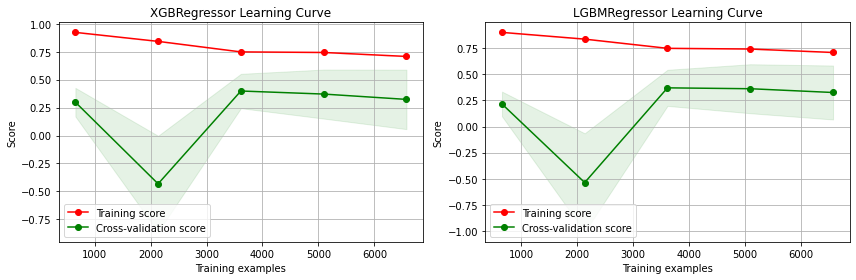

In [139]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [140]:
# run models on KFold
for model in models:
    run_model(orig_feats, model, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3975, r2: 57.6%
LGBMRegressor RMSE: 0.3972, r2: 57.7%


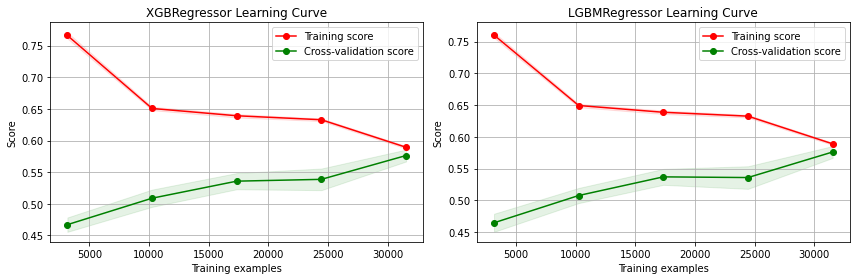

In [141]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Run models on original darksky.net features extended with time based features

In [142]:
# extend original features with new time based ones
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability',
              'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windSpeed',
              'icon_num', 'Autumn', 'Spring', 'Summer', 'Winter',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend']

In [143]:
# run models on time series split
for model in models:
    run_model(time_feats, model, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.3997, r2: 50.7%
LGBMRegressor RMSE: 0.3983, r2: 50.9%


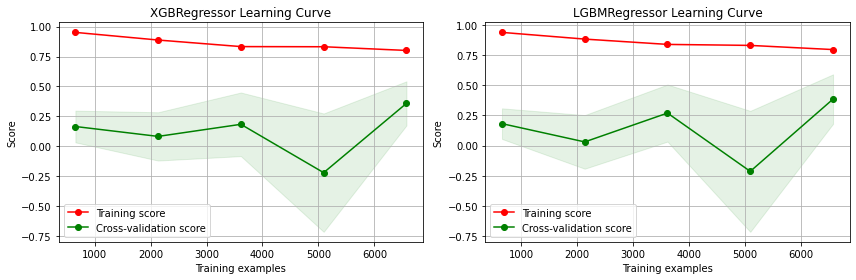

In [144]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [145]:
# run models on KFold
for model in models:
    run_model(time_feats, model, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3504, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


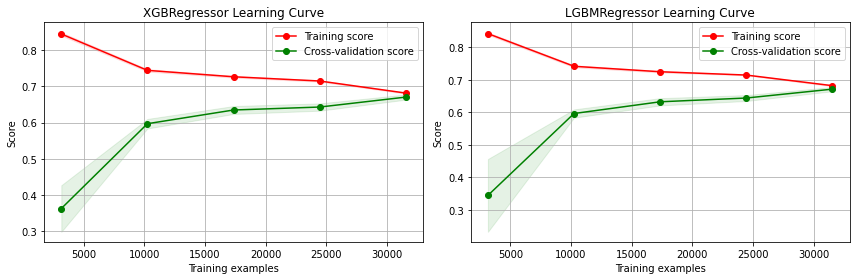

In [146]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Run models on all features except features realted to PM2.5

In [147]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = [
                  # Niepodleglosci
                  'PM25_nie', 'PM25_nie_log', 'PM25_nie_mean', 'mean_PM25_nie_per_day',
                  'mean_PM25_nie_log_per_day', 'median_PM25_nie_per_day', 'median_PM25_nie_log_per_day',
                  'mean_PM25_nie_per_month', 'mean_PM25_nie_log_per_month', 'median_PM25_nie_per_month',
                  'median_PM25_nie_log_per_month',
                  # Wokalna
                  'PM25_wok', 'PM25_wok_log', 'PM25_wok_mean', 'mean_PM25_wok_per_day', 
                  'mean_PM25_wok_log_per_day', 'median_PM25_wok_per_day', 'median_PM25_wok_log_per_day',
                  'mean_PM25_wok_per_month', 'mean_PM25_wok_log_per_month', 'median_PM25_wok_per_month',
                  'median_PM25_wok_log_per_month'
                  ]
                  
    return [x for x in feats if x not in black_list]

In [148]:
#get feats
feats = get_feats(df_train)

In [149]:
# run models on time series split
for model in models[1:]:
    run_model(feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.5067, r2: 20.0%
RandomForestRegressor RMSE: 0.4670, r2: 32.3%
XGBRegressor RMSE: 0.3672, r2: 57.9%
LGBMRegressor RMSE: 0.3681, r2: 57.7%


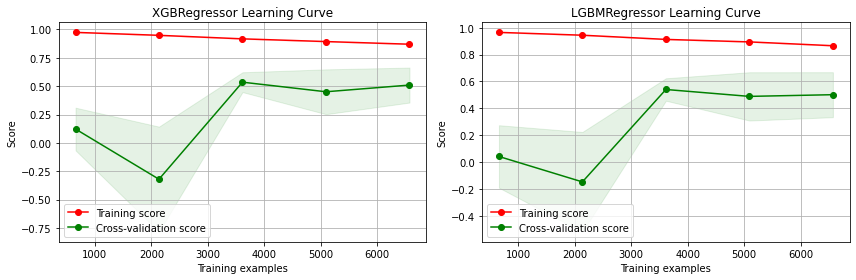

In [152]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [150]:
# run models on KFold
for model in models[1:]:
    run_model(feats, model, kf)

DecisionTreeRegressor RMSE: 0.4373, r2: 48.7%
RandomForestRegressor RMSE: 0.4264, r2: 51.2%
XGBRegressor RMSE: 0.3029, r2: 75.4%
LGBMRegressor RMSE: 0.3033, r2: 75.3%


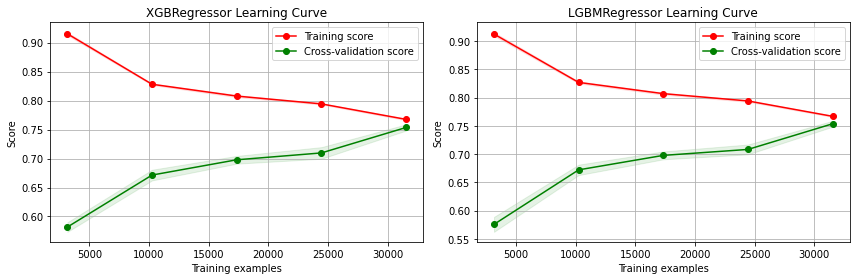

In [151]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[3:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

##Parameters tuning with HyperOpt on all features except features realted to PM2.5

###XGBoost Depth-wise

In [153]:
X = df_train[feats].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='depthwise',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2318, r2: 85.7%
RMSE: 0.2655, r2: 81.2%
RMSE: 0.2083, r2: 88.4%
RMSE: 0.3776, r2: 61.9%
RMSE: 0.2866, r2: 78.1%
RMSE: 0.2054, r2: 88.7%
RMSE: 0.2093, r2: 88.3%
RMSE: 0.2056, r2: 88.7%
RMSE: 0.2068, r2: 88.6%
RMSE: 0.1939, r2: 90.0%
100%|██████████| 10/10 [04:21<00:00, 26.18s/it, best loss: 0.19393564541896433]
The best params:  {'colsample_bytree': 0.8, 'gamma': 0.65, 'learning_rate': 0.17500000000000002, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 180, 'subsample': 0.7841367761456286}


In [154]:
# initite model with best parameters
XGB_model_depth = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_model_depth.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.65,
             grow_policy='depthwise', importance_type='gain',
             learning_rate=0.17500000000000002, max_delta_step=0, max_depth=4,
             min_child_weight=3.0, missing=None, n_estimators=180, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7841367761456286, tree_method='hist',
             verbosity=1)

In [155]:
perm = PermutationImportance(XGB_model_depth).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0557 ± 0.0009,windSpeed_rolling24h
0.0375 ± 0.0009,dewPoint_rolling168h
0.0307 ± 0.0005,visibility
0.0259 ± 0.0007,windSpeed_lag1h
0.0258 ± 0.0009,humidity
0.0248 ± 0.0003,dewPoint
0.0238 ± 0.0008,year
0.0223 ± 0.0006,windSpeed_rolling12h
0.0203 ± 0.0005,hour
0.0184 ± 0.0008,mean_apparentTemperature_per_month


###XGBoost Leaf-wise

In [156]:
def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='lossguide',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2096, r2: 88.3%
RMSE: 0.2098, r2: 88.3%
RMSE: 0.2914, r2: 77.3%
RMSE: 0.2036, r2: 88.9%
RMSE: 0.2128, r2: 87.9%
RMSE: 0.3046, r2: 75.2%
RMSE: 0.2025, r2: 89.1%
RMSE: 0.2183, r2: 87.3%
RMSE: 0.2004, r2: 89.3%
RMSE: 0.2096, r2: 88.3%
100%|██████████| 10/10 [04:05<00:00, 24.50s/it, best loss: 0.20037414920466032]
The best params:  {'colsample_bytree': 1.0, 'gamma': 0.65, 'learning_rate': 0.275, 'max_depth': 4, 'min_child_weight': 10.0, 'n_estimators': 110, 'subsample': 0.7716740852278977}


In [157]:
XGB_model_leaf = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
XGB_model_leaf.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.65,
             grow_policy='lossguide', importance_type='gain',
             learning_rate=0.275, max_delta_step=0, max_depth=4,
             min_child_weight=10.0, missing=None, n_estimators=110, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=2020,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7716740852278977, tree_method='hist',
             verbosity=1)

In [158]:
perm = PermutationImportance(XGB_model_leaf).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0961 ± 0.0022,mean_apparentTemperature_per_month
0.0408 ± 0.0004,dewPoint_rolling168h
0.0395 ± 0.0009,windSpeed_rolling12h
0.0382 ± 0.0007,windSpeed_rolling24h
0.0356 ± 0.0010,visibility
0.0351 ± 0.0009,dewPoint
0.0316 ± 0.0010,windSpeed_lag1h
0.0316 ± 0.0008,humidity
0.0268 ± 0.0005,temperature_rolling168h
0.0255 ± 0.0009,humidity_lag1h


###LightGBM

In [159]:
def objective(space):
    
    LGBM_model = lgb.LGBMRegressor(
                max_depth = int(space['max_depth']),
                n_estimators = space['n_estimators'],
                num_leaves = space['num_leaves'],
                min_child_weight = space['min_child_weight'],
                subsample = space['subsample'],
                learning_rate = space['learning_rate'],
                gamma = space['gamma'],
                colsample_bytree = space['colsample_bytree'],
                objective='regression',
                random_state=random_state
                )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = LGBM_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'num_leaves' : hp.choice('num_leaves', np.arange(10, 30, 1, dtype=int)),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2059, r2: 88.7%
RMSE: 0.2183, r2: 87.3%
RMSE: 0.2024, r2: 89.1%
RMSE: 0.2018, r2: 89.1%
RMSE: 0.2527, r2: 83.0%
RMSE: 0.2418, r2: 84.4%
RMSE: 0.1764, r2: 91.7%
RMSE: 0.2601, r2: 81.9%
RMSE: 0.2053, r2: 88.8%
RMSE: 0.1664, r2: 92.6%
100%|██████████| 10/10 [01:38<00:00,  9.82s/it, best loss: 0.16635779590566718]
The best params:  {'colsample_bytree': 0.8, 'gamma': 0.75, 'learning_rate': 0.17500000000000002, 'max_depth': 5, 'min_child_weight': 8.0, 'n_estimators': 223, 'num_leaves': 16, 'subsample': 0.9068191814846659}


In [160]:
# initite model with best parameters
LGBM_model = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)
LGBM_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              gamma=0.75, importance_type='split',
              learning_rate=0.17500000000000002, max_depth=5,
              min_child_samples=20, min_child_weight=8.0, min_split_gain=0.0,
              n_estimators=223, n_jobs=-1, num_leaves=16,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.9068191814846659,
              subsample_for_bin=200000, subsample_freq=0)

In [161]:
perm = PermutationImportance(LGBM_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0582 ± 0.0006,mean_apparentTemperature_per_month
0.0355 ± 0.0008,windSpeed_rolling12h
0.0349 ± 0.0009,dewPoint_rolling168h
0.0327 ± 0.0009,windSpeed_rolling24h
0.0244 ± 0.0004,visibility
0.0224 ± 0.0005,dewPoint
0.0221 ± 0.0009,hour
0.0221 ± 0.0006,windSpeed_lag1h
0.0207 ± 0.0004,temperature_rolling168h
0.0191 ± 0.0003,windBearing_rolling72h


###Models evaluation

In [162]:
models = [XGB_model_depth, XGB_model_leaf, LGBM_model]

for model in models:
    run_model(feats, model, kf)

XGBRegressor RMSE: 0.2302, r2: 85.8%
XGBRegressor RMSE: 0.2365, r2: 85.0%
LGBMRegressor RMSE: 0.2123, r2: 87.9%


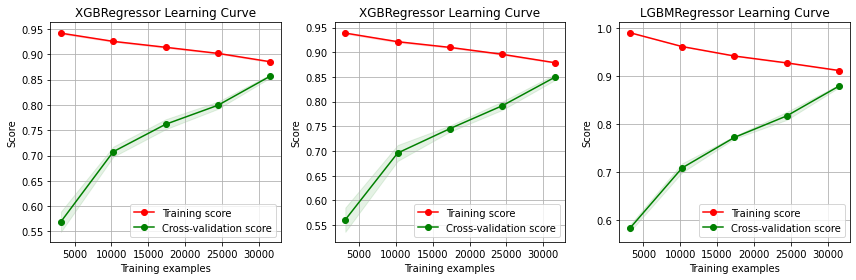

In [163]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

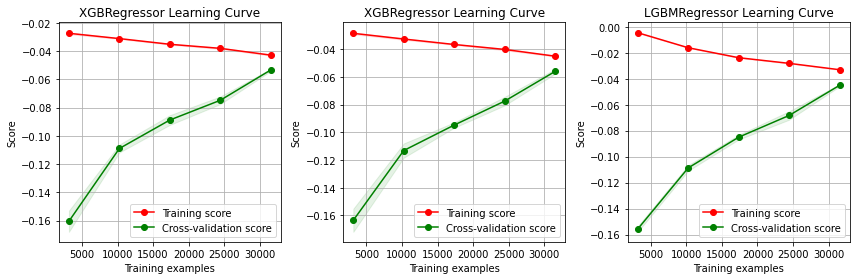

In [164]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(feats, model, kf, 'neg_mean_squared_error', ax=ax)
fig.tight_layout()
plt.show()

##Feature Selection 

In [165]:
# select top25 features
selected_feats = ['year',
                  'hour',
                  'weekday',
                  'visibility',
                  'visibility_lag1h',
                  'visibility_rolling72h',
                  'mean_visibility_per_day',
                  'dewPoint',
                  'dewPoint_rolling72h',
                  'dewPoint_rolling168h',
                  'humidity',
                  'humidity_lag1h',
                  'mean_apparentTemperature_per_month',
                  'median_apparentTemperature_per_day',
                  'temperature_rolling168h',
                  'cloudCover_rolling24h',
                  'uvIndex_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing',
                  'windBearing_lag1h',
                  'windBearing_rolling24h',
                  'windBearing_rolling72h',
                  'windBearing_rolling168h']


In [179]:
# select top20 features
selected_feats2 = ['year',
                  'dayofyear',
                  'weekday',
                  'hour',
                  'visibility',
                  'humidity',
                  'apparentTemperature',
                  'mean_apparentTemperature_per_month',
                  'temperature',
                  'temperature_rolling168h',
                  'mean_temperature_per_month',
                  'dewPoint',
                  'dewPoint_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing_lag1h',
                  'windBearing_rolling168h',
                  'windBearing_rolling72h',
                  'uvIndex_rolling168h'
                  ]

##Parameters tuning with HyperOpt on selected features

###XGBoost Depth-wise

In [194]:
X = df_train[selected_feats2].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='depthwise',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2292, r2: 86.0%
RMSE: 0.3028, r2: 75.5%
RMSE: 0.2319, r2: 85.6%
RMSE: 0.2829, r2: 78.6%
RMSE: 0.2592, r2: 82.1%
RMSE: 0.2652, r2: 81.2%
RMSE: 0.5438, r2: 21.1%
RMSE: 0.2214, r2: 86.9%
RMSE: 0.2297, r2: 85.9%
RMSE: 0.2135, r2: 87.8%
100%|██████████| 10/10 [00:47<00:00,  4.76s/it, best loss: 0.2135345631026939]
The best params:  {'colsample_bytree': 0.65, 'gamma': 0.6000000000000001, 'learning_rate': 0.35000000000000003, 'max_depth': 4, 'min_child_weight': 8.0, 'n_estimators': 150, 'subsample': 0.9216716787167103}


In [195]:
# initite models with best parameters
XGB_model_depth_v2 = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)

###XGBoost Leaf-wise

In [196]:
def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           tree_method='hist',
                           grow_policy='lossguide',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2945, r2: 76.9%
RMSE: 0.2920, r2: 77.2%
RMSE: 0.2311, r2: 85.7%
RMSE: 0.2293, r2: 86.0%
RMSE: 0.2763, r2: 79.6%
RMSE: 0.8999, r2: -116.1%
RMSE: 0.3255, r2: 71.7%
RMSE: 0.3277, r2: 71.3%
RMSE: 0.2139, r2: 87.8%
RMSE: 0.2355, r2: 85.2%
100%|██████████| 10/10 [00:43<00:00,  4.40s/it, best loss: 0.21389242655470497]
The best params:  {'colsample_bytree': 0.9500000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 4.0, 'n_estimators': 220, 'subsample': 0.7948940458318988}


In [197]:
# initite models with best parameters
XGB_model_leaf_v2 = xgb.XGBRegressor(**best, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)

###LightGBM

In [198]:
def objective(space):
    
    LGBM_model = lgb.LGBMRegressor(
                max_depth = int(space['max_depth']),
                n_estimators = space['n_estimators'],
                num_leaves = space['num_leaves'],
                min_child_weight = space['min_child_weight'],
                subsample = space['subsample'],
                learning_rate = space['learning_rate'],
                gamma = space['gamma'],
                colsample_bytree = space['colsample_bytree'],
                objective='regression',
                random_state=random_state
                )
    
    for train_idx, test_idx in kf.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = LGBM_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice ('max_depth', np.arange(2, 8, 1, dtype=int)),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 500, 2, dtype=int)),
        'num_leaves' : hp.choice('num_leaves', np.arange(10, 30, 1, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2346, r2: 85.3%
RMSE: 0.2126, r2: 87.9%
RMSE: 0.2437, r2: 84.2%
RMSE: 0.2517, r2: 83.1%
RMSE: 0.3022, r2: 75.6%
RMSE: 0.2531, r2: 82.9%
RMSE: 0.2149, r2: 87.7%
RMSE: 0.2903, r2: 77.5%
RMSE: 0.2379, r2: 84.9%
RMSE: 0.2042, r2: 88.9%
100%|██████████| 10/10 [00:12<00:00,  1.27s/it, best loss: 0.2041962797531294]
The best params:  {'colsample_bytree': 0.8, 'gamma': 0.6000000000000001, 'learning_rate': 0.5, 'max_depth': 4, 'min_child': 3.0, 'n_estimators': 88, 'num_leaves': 19, 'subsample': 0.8225636232716366}


###Models evaluation

In [199]:
# initite models with best parameters
LGBM_model_v2 = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)

In [200]:
models = [XGB_model_depth_v2, XGB_model_leaf_v2, LGBM_model_v2]

for model in models:
    run_model(selected_feats2, model, kf)

XGBRegressor RMSE: 0.2476, r2: 83.5%
XGBRegressor RMSE: 0.2732, r2: 80.0%
LGBMRegressor RMSE: 0.2576, r2: 82.2%


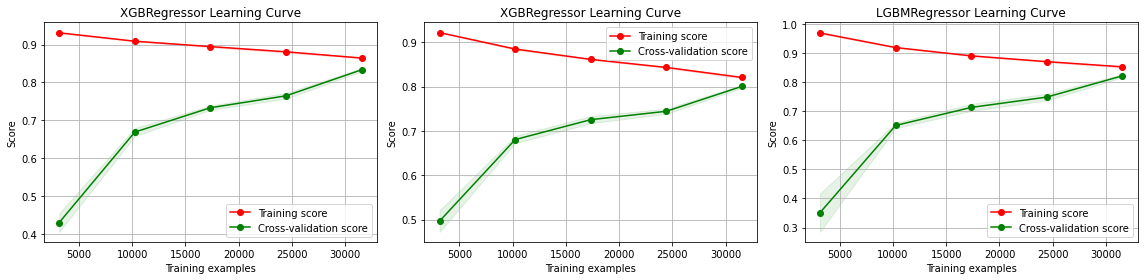

In [201]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(selected_feats2, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

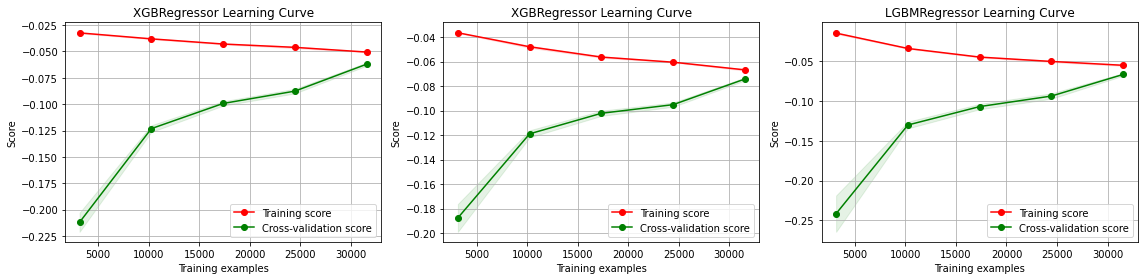

In [202]:
fig=plt.figure(figsize=(16,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(selected_feats2, model, kf, 'neg_mean_squared_error', ax=ax)
fig.tight_layout()
plt.show()

## Predict on test data

In [203]:
# prepare X train for training on all feats and selected feats
X_train = df_train[feats].values
X_train_v2 = df_train[selected_feats2].values

# prepare X test for predicting on all feats and selected feats
X_test = df_test[feats].values
X_test_v2 = df_test[selected_feats2].values

# prepare y
y = df_train['PM25_nie_log'].values

In [204]:
# fit models on all feats
XGB_model_depth.fit(X_train, y)
XGB_model_leaf.fit(X_train, y)
LGBM_model.fit(X_train, y)

# predict on all feats 
y_test_XGB_depth = XGB_model_depth.predict(X_test)
y_test_XGB_leaf = XGB_model_leaf.predict(X_test)
y_test_LGBM = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth'] = np.expm1(y_test_XGB_depth)
df_test['PM25_nie_pred_xgb_leaf'] = np.expm1(y_test_XGB_leaf)
df_test['PM25_nie_pred_lgbm'] = np.expm1(y_test_LGBM)

In [205]:
# fit models on selected feats
XGB_model_depth_v2.fit(X_train_v2, y)
XGB_model_leaf_v2.fit(X_train_v2, y)
LGBM_model_v2.fit(X_train_v2, y)

# predict on selected feats
y_test_XGB_depth_v2 = XGB_model_depth_v2.predict(X_test_v2)
y_test_XGB_leaf_v2 = XGB_model_leaf_v2.predict(X_test_v2)
y_test_LGBM_v2 = LGBM_model_v2.predict(X_test_v2)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_v2'] = np.expm1(y_test_XGB_depth_v2)
df_test['PM25_nie_pred_xgb_leaf_v2'] = np.expm1(y_test_XGB_leaf_v2)
df_test['PM25_nie_pred_lgbm_v2'] = np.expm1(y_test_LGBM_v2)

In [206]:
# check RMSE for test data on all feats
xgb_rmse_depth = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth']))
xgb_rmse_leaf = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf']))
lgbm_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm']))

# check r2 for test data on all feats
xgb_r2_depth = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth'])
xgb_r2_leaf = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf'])
lgbm_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm'])


# check RMSE for test data on selected feats
xgb_rmse_depth_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_v2']))
xgb_rmse_leaf_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_v2']))
lgbm_rmse_v2 = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_v2']))

# check r2 for test data for both Light GBM models
xgb_r2_depth_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_v2'])
xgb_r2_leaf_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_v2'])
lgbm_r2_v2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_v2'])

In [207]:
print("-----RMSE and r2 results on the test data using all features-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))
print(" ")
print("-----RMSE and r2 results on the test data using selected features-----")
print("XGBoost_Depth_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_v2, 100*np.mean(xgb_r2_depth_v2)))
print("XGBoost_Leaf_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_v2, 100*np.mean(xgb_r2_leaf_v2)))
print("LightGBM_v2: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_v2, 100*np.mean(lgbm_r2_v2)))

-----RMSE and r2 results on the test data using all features-----
XGBoost_Depth: RMSE: 7.6524, r2: 46.5%
XGBoost_Leaf: RMSE: 8.6142, r2: 32.2%
LightGBM: RMSE: 7.3691, r2: 50.4%
 
-----RMSE and r2 results on the test data using selected features-----
XGBoost_Depth_v2: RMSE: 7.7637, r2: 44.9%
XGBoost_Leaf_v2: RMSE: 6.9460, r2: 55.9%
LightGBM_v2: RMSE: 8.0842, r2: 40.3%


In [208]:
months = df_test.month.unique().tolist()
months

[7, 8, 9, 10, 11, 12]

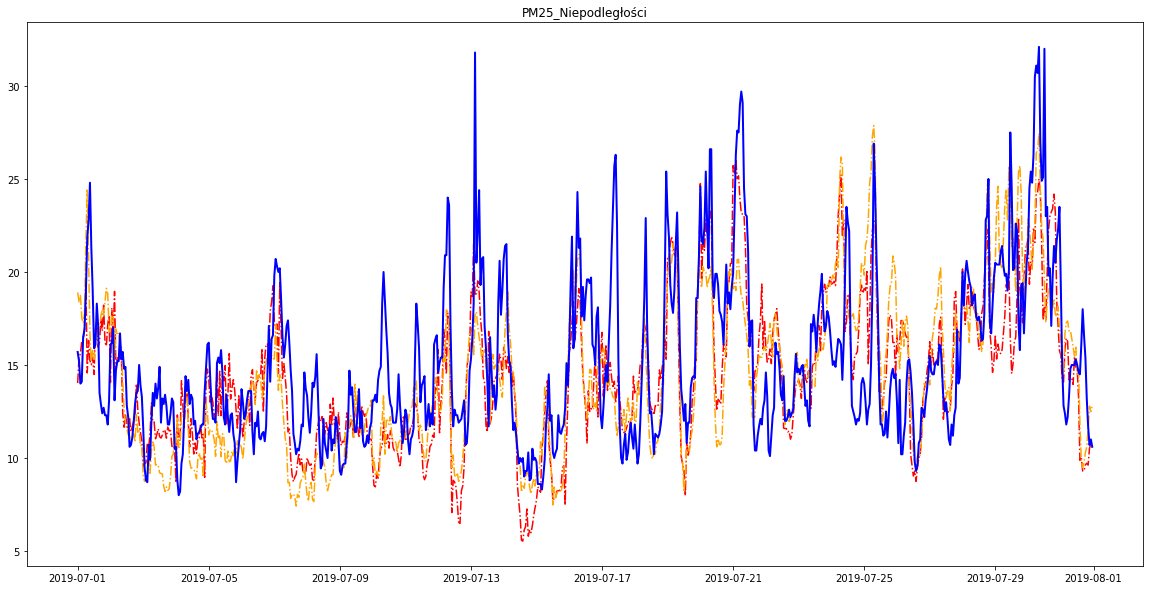

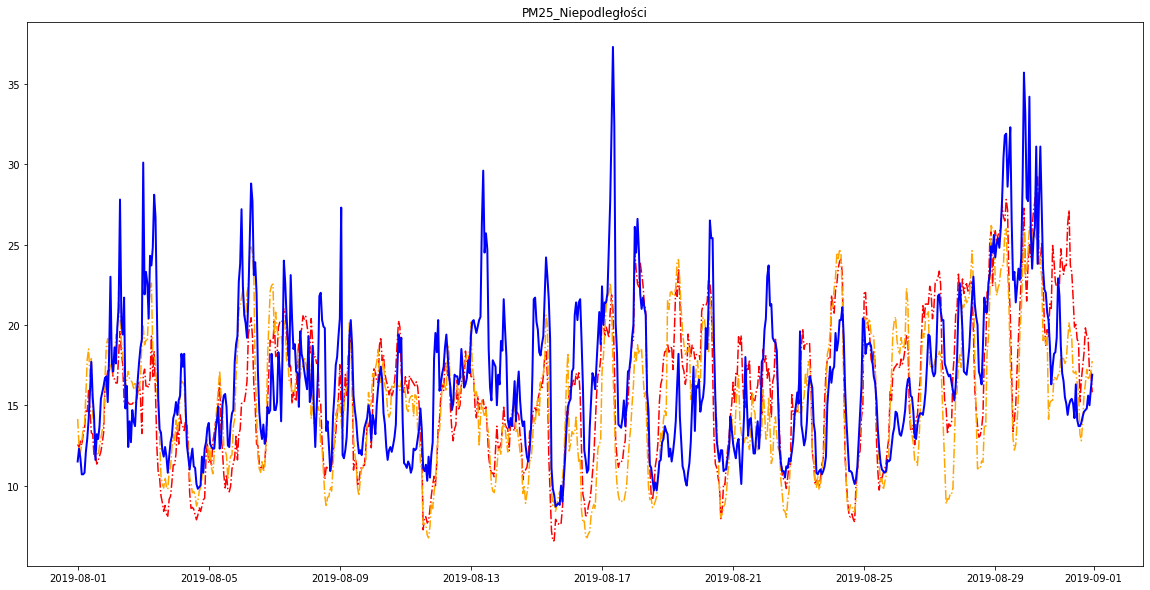

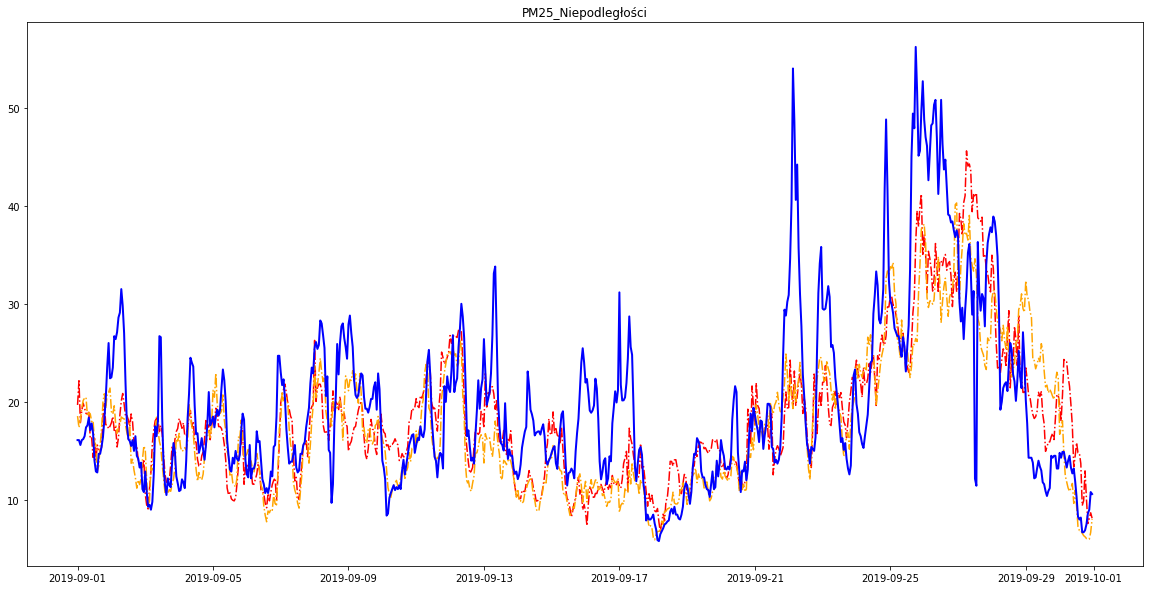

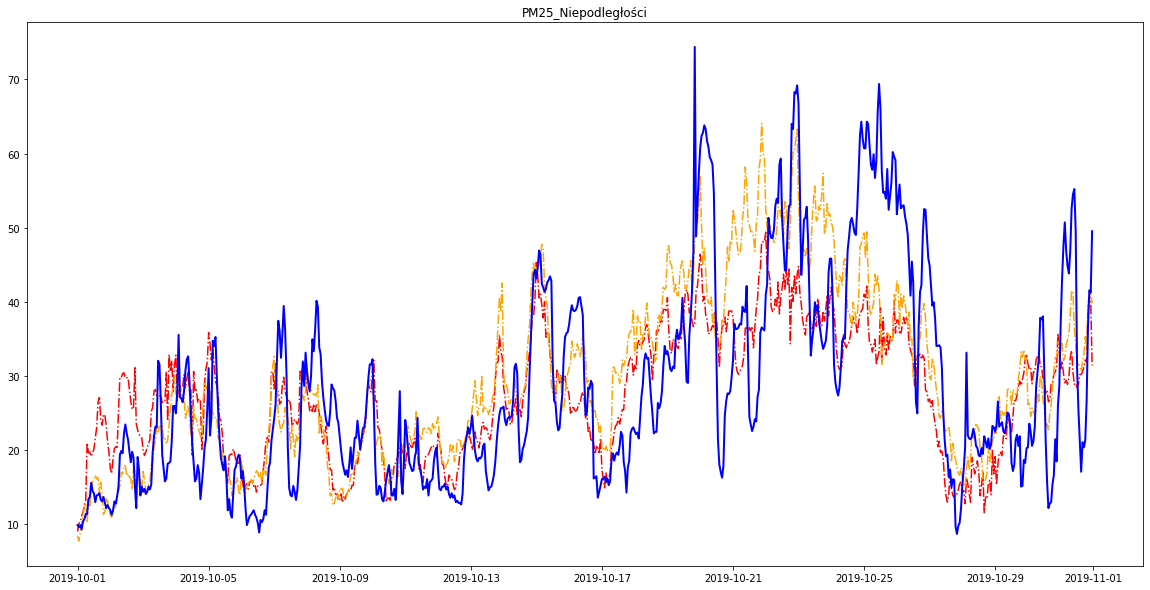

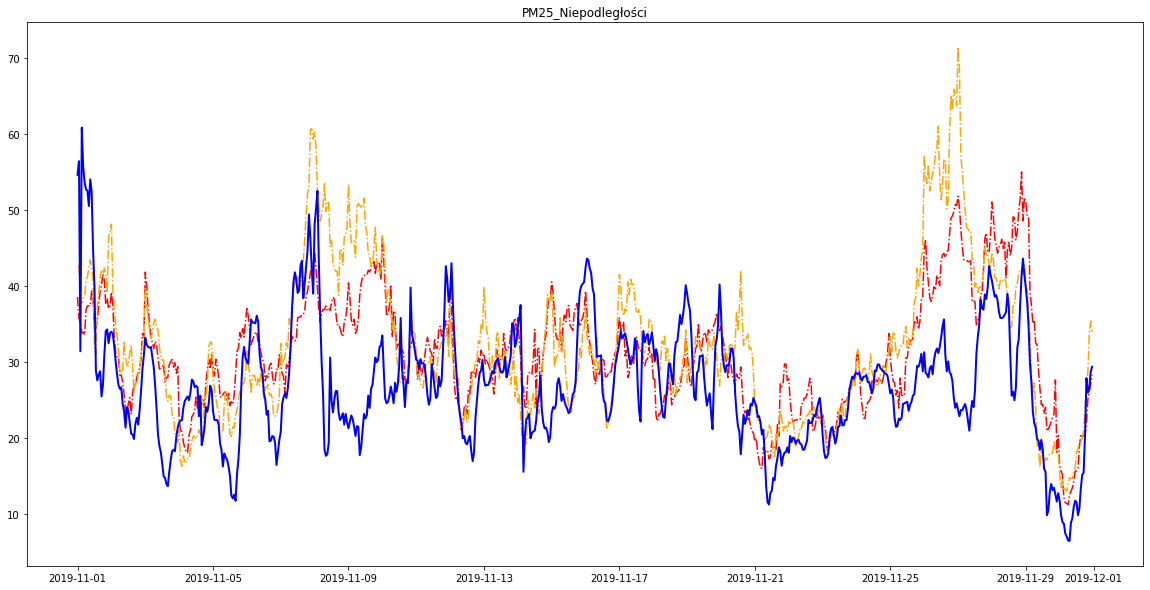

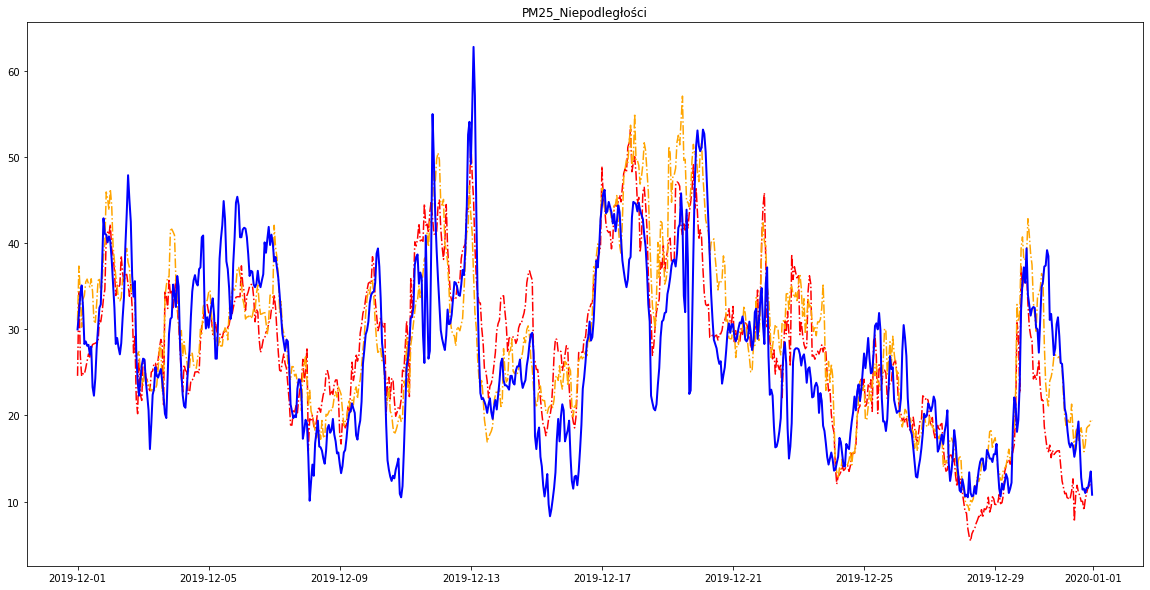

In [209]:
for mth in months:
    test_mask = df_test['month'] == mth
    plt.figure(figsize=(20,10))
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_leaf_v2'], color='red', linestyle='dashdot') #forecast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_lgbm'], color='orange', linestyle='dashdot') #forecast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie'], color='blue', linewidth = 2) #actual

    plt.title('PM25_Niepodległości')
    plt.show()